In [85]:
# %% Import Libraries
#This is a test
import os
import pickle
import scipy.io
import numpy as np
import pandas as pd
import torch as tc
import matplotlib.pyplot as plt

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split

import matplotlib.patches as mpatches
from tqdm import tqdm
from bptt.models import Model
import model_anafunctions as func

from matplotlib.patches import Rectangle
from matplotlib.lines import Line2D

plt.rcParams['font.size'] = 20

In [52]:
# FUNCTIONS

def Hyper_mod(mpath,data_path):
    file=open(os.path.join(mpath,'hypers.pkl').replace("\\","/"),'rb')
    hyper=pickle.load(file)
    file.close()
    hyper['data_path']=os.path.join(data_path,'Training_data.npy').replace('\\','/')
    hyper['inputs_path']=os.path.join(data_path,'Training_inputs.npy').replace('\\','/')
    print(hyper['device_id'])
    hyper['device_id'] = 0
    print(hyper['device_id'])    
    full_name = open(os.path.join(mpath,'hypers.pkl').replace("\\","/"),"wb")                      # Name for training data
    pickle.dump(hyper,full_name)            # Save train data
    #close save instance 
    full_name.close()

def Classifier_events(X_data,X_dataT,X_model,X_modelT,Event,Trainexp,Testexp):
    # Train classifier with training data
    ND_train = Event[Trainexp]
    ND_test = Event[Testexp]

    #%% Next Decisions
    score_data=[]
    score_model=[]
    score_modelSh=[]
    score_dataSh=[]

    clf = LinearDiscriminantAnalysis()
    for i in range(1000):
        # Classifying data
        X_train=X_data
        y_train=ND_train
        X_test = X_dataT
        y_test = ND_test
        clf.fit(X_train,y_train)
        score_data.append(clf.score(X_test,y_test))

        # Classifying data Shuffle
        list_trials=np.linspace(0,X_data.shape[0]-1,X_data.shape[0]).astype(int)
        np.random.shuffle(list_trials)
        y=ND_train[list_trials]
        random_state=0
        X_trainS, X_testS, y_trainS, y_testS = train_test_split(
            X_train, y, test_size=0.2, stratify=y, random_state=0
            )
        clf.fit(X_trainS,y_trainS)
        score_dataSh.append(clf.score(X_testS,y_testS))

        # Classifying model
        X_trainM=X_model
        y_trainM=ND_train
        X_testM = X_modelT
        y_testM = ND_test
        clf.fit(X_trainM,y_trainM)
        score_model.append(clf.score(X_testM,y_testM))
        
        # Classifying model Shuffle
        list_trials=np.linspace(0,X_data.shape[0]-1,X_data.shape[0]).astype(int)
        np.random.shuffle(list_trials)
        y=ND_train[list_trials]
        X_trainMS, X_testMS, y_trainMS, y_testMS = train_test_split(
            X_trainM, y, test_size=0.2, stratify=y, random_state=0
            )
        clf.fit(X_trainMS,y_trainMS)
        score_modelSh.append(clf.score(X_testMS,y_testMS))


    fig, ax = plt.subplots()
    Models = ['Data', 'Shuffle','Model','Shuffle']
    ax.boxplot([score_data,score_dataSh,score_model,score_modelSh],labels=Models)
    ax.set_ylabel('Test Score')
    ax.set_title('Classifier')
    plt.show()

    return np.array(score_data).mean(),np.array(score_dataSh).mean(),np.array(score_model).mean(),np.array(score_modelSh).mean()

In [69]:
# Behavioural data to classify data
# ND: Next Decision (Gamble - Safe)
# RW: Reward (Gamble - Safe - None)
# B_se: Blocks (High - Medium - Low)

#Behaviour path
behaviour_path='D:/_work_cestarellas/Analysis/PLRNN/Session_Selected/OFC/DM01_7_220524'

# Selection of the file
os.chdir(behaviour_path)
list_files = os.listdir(behaviour_path)
for i in list_files:
    if i.find('Behaviour')>0:
        Behaviour_name = i

# Load data
# Open the Behaviour file
Bdata = scipy.io.loadmat(Behaviour_name)
BehData = Bdata[list(Bdata.keys())[-1]]

# Classification of trials following the behabiour
GambleRewardTrials = np.where((BehData[:,12]==1) & (BehData[:,13]==1))[0]
GambleNoRewardTrials =  np.where((BehData[:,12]==1) & (BehData[:,13]==0))[0]
SafeRewardTrials = np.where((BehData[:,12]==0) & (BehData[:,13]==1))[0]
SafeNoRewardTrials = np.where((BehData[:,12]==0) & (BehData[:,13]==0))[0]
NoRespondingTrials = np.where(BehData[:,10]==1)[0]


# Next Decision (G,S)
ND = (BehData[:,12]==1)*1+(BehData[:,12]==0)*0

# Reward (Gamble, Safe, Nothing)
RW = (BehData[:,12]==1)*(BehData[:,13])*2+(BehData[:,13])*(BehData[:,12]==0)*1

# Blocks (High, Medium, Low)
blocks=np.unique(BehData[:,5])
if len(blocks)==3:
    B_se=(BehData[:,5]==blocks[0])*0+(BehData[:,5]==blocks[1])*1+(BehData[:,5]==blocks[2])*2
elif len(blocks)==2:
    B_se=(BehData[:,5]==blocks[0])*0+(BehData[:,5]==blocks[1])*1
elif len(blocks)<2:
    print("There is no different blocks to classify the data")
else:
    print("This is not the original task")


In [62]:
# First point: 
# Obtain the original and the training data to train the classifier

#%% Load Data and Behaviour
################################ Directories and files to modify ################################ 
# Select Path for multi-unit data
data_path = 'D:\\_work_cestarellas\\Analysis\\Pack_Daniel_project\\Preprocess_model\\bptt_DM01_7\\neuralactivity\\datasets\\' 
#data_path = 'D:/_work_cestarellas/Analysis/PLRNN/noautoencoder/neuralactivity/OFC/CE17/L6/Test0/datasets/' 
# Select Path for Models (Folder containing the specific models to test)
model_path = 'D:\\_work_cestarellas\Analysis\\Pack_Daniel_project\\Preprocess_model\\bptt_DM01_7\\results'
#model_path = 'D:/_work_cestarellas/Analysis/PLRNN/noautoencoder/results/Tuning_OFC_CE17_221008'
#meta information
Meta_file_path = "D:\\_work_cestarellas\\Analysis\\Pack_Daniel_project\\Preprocess_model\\bptt_DM01_7\\neuralactivity\\datasets\\Metadata.pkl"
#Behaviour path
behaviour_path='D:/_work_cestarellas/Analysis/PLRNN/Session_Selected/OFC/DM01_7_220524'

# Loading models and simulations
model_name = 'DataTrainingH768_lm1_1e-05_lm2_128_lm3_00_seql_400/001'
#model_name = 'CE1701_HU_256_l1_0.001_l2_08_l3_00_SL_400_encdim_65/001'

## Loading recorded neuronal activity (pre-processesed)
mpath=os.path.join(model_path,model_name).replace('\\','/')

train_n,train_i = func.load_data(data_path,'Training')

Hyper_mod(mpath,data_path)

# Loading Model
num_epochs = 150000
m = Model()
m.init_from_model_path(mpath, epoch=num_epochs)
m.eval()

# Generation Training Data
ModelS=[]
for w_index in tqdm(range(len(train_n))):
    data_trial=tc.from_numpy(train_n[w_index]).float()          # tensor of neuronal data for initial trial data
    input_trial = tc.from_numpy(train_i[w_index]).float()
    length_sim = input_trial.shape[0]
    X, _ = m.generate_free_trajectory(data_trial,input_trial,length_sim,w_index)
    ModelS.append(X[:,:])

# Concatenating signals
Nseries,_=func.concatenate_list(train_n,0)          # recorded activity
Iseries,_=func.concatenate_list(train_i,0)          # external input
Mseries,_=func.concatenate_list(ModelS,0)           # simulated activity


# Second point:
# Load Metadata
file=open(os.path.join(data_path,'Metadata.pkl'),'rb')
Metadata=pickle.load(file)
file.close()

test_n,test_i = func.load_data(data_path,'Test')

# Obtaining the original data for test trials and geneterate test trials by the model
_, W1t, W2t, _, _, Ct = m.get_latent_parameters()

# Transform tensor to numpy format
W2 = W2t.detach().numpy().transpose(1,2,0)
W1 = W1t.detach().numpy().transpose(1,2,0)
C = Ct.detach().numpy()
# General Parameters
Ntraining_trials=len(train_n)
Ntest_trials = len(test_n)
num_neurons=train_n[0].shape[1]

# Generate Latent states for Test Trials
# Identificating Test Trials in the training trial set
t_prev = [i for i in Metadata["Training2Test"]]
t_post = [i+1 for i in Metadata["Training2Test"]]

# Computing W matrices for test trials
W2_test = np.empty((W2.shape[0],W2.shape[1],len(Metadata["TestTrials"])))
W1_test = np.empty((W1.shape[0],W1.shape[1],len(Metadata["TestTrials"])))
for i in range(len(t_prev)):
    W2_test[:,:,i] = (W2[:,:,t_prev[i]]+W2[:,:,t_post[i]])/2.0
    W1_test[:,:,i] = (W1[:,:,t_prev[i]]+W1[:,:,t_post[i]])/2.0
#Generate Latent states
ModelT = []

#Generate Latent states
W1_ind = [tc.from_numpy(W1_test[:,:,i]).float() for i in range(len(t_prev))]
W2_ind = [tc.from_numpy(W2_test[:,:,i]).float() for i in range(len(t_prev))]
for i in range(len(W1_ind)):
    data_test=tc.from_numpy(test_n[i]).float()
    input_test=tc.from_numpy(test_i[i]).float()
    T0=test_n[i].shape[0]
    X, _ = m.generate_test_trajectory(data_test[0:11,:],W2_ind[i],W1_ind[i],input_test, T0,i)
    ModelT.append(X)

# Concatenating signals
IseriesT,_=func.concatenate_list(test_i,0)          # external input
MseriesT,_=func.concatenate_list(ModelT,0)           # simulated activity
NseriesT,_=func.concatenate_list(test_n,0)

0
0
Chosen model is clipped shPLRNN, the bases Parameter has no effect here!


100%|██████████| 88/88 [00:10<00:00,  8.65it/s]


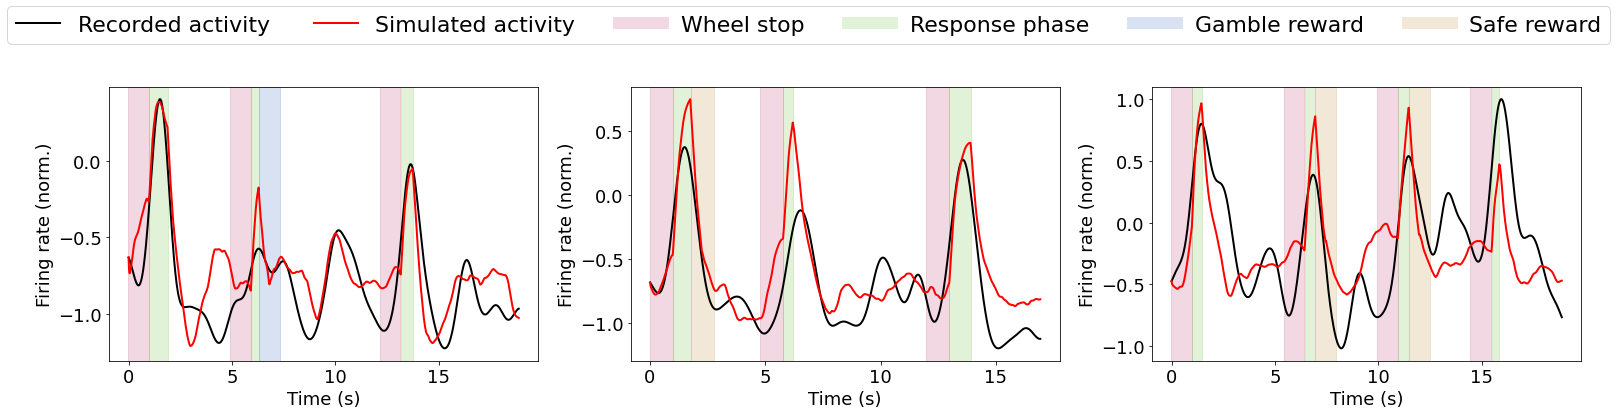

In [90]:

################################ Parameters to modify ################################ 
# Selection of data
eneu = 36                                                       # Selection of neuron
# Plot properties
# colors
c_recorded_activity = 'black'                                   # Color for line: Recorded Activity 
c_simulated_activity = 'red'                                    # Color for line: Simulated Activity
c_stop = '#C13E71'                                              # Color for area: Wheel stop phase
c_cue = '#71C13E'                                               # Color for area: Response phase
c_gamble = '#3E71C1'                                            # Color for area: Gamble reward
c_safe = '#C18E3E'                                              # Color for area: Safe reward
alpha_value = 0.2                                               # Transparency level for sections of the trial (stop wheel, cue, reward g/s)
#####################################################################################

# Create subplots
plt.rcParams['font.size'] = 18
fig, axs = plt.subplots(1, 3, figsize=(22, 5))
for ax,it in zip(axs,range(3)):
    # Creating x vector. (Time)
    vec_length = test_n[it].shape[0]
    temp_vec = np.linspace(0,vec_length,vec_length)*0.02
    
    # Creating the areas for each trial
    #Wheel Stop
    #Sections Cue
    ini_stop = np.where(np.diff(test_i[it][:,0])==1.)[0]-50
    end_stop = np.where(np.diff(test_i[it][:,0])==1.)[0]
    stop_sections = [(ini_stop[i]*0.02,end_stop[i]*0.02) for i in range(len(ini_stop))]
    #Sections Cue
    ini_cue = np.where(np.diff(test_i[it][:,0])==1.)[0]+1
    end_cue = np.where(np.diff(test_i[it][:,0])==-1.)[0]+1
    cue_sections = [(ini_cue[i]*0.02,end_cue[i]*0.02) for i in range(len(ini_cue))]
    #Sections Reward Gamble
    ini_grew = np.where(np.diff(test_i[it][:,1])==4.)[0]+1
    end_grew = np.where(np.diff(test_i[it][:,1])==-4.)[0]+1+25
    grew_sections = [(ini_grew[i]*0.02,end_grew[i]*0.02) for i in range(len(ini_grew))]
    #Sections Reward Safe
    ini_srew = np.where(np.diff(test_i[it][:,2])==1.)[0]+1
    end_srew = np.where(np.diff(test_i[it][:,2])==-1.)[0]+1+25
    srew_sections = [(ini_srew[i]*0.02,end_srew[i]*0.02) for i in range(len(ini_srew))]

    # Ploting the data for each concatenated trial
    ax.plot(temp_vec,test_n[it][:,eneu],color=c_recorded_activity, lw = 2,label="Recorded activity")
    ax.plot(temp_vec,ModelT[it][:,eneu],color=c_simulated_activity, lw = 2,label="Simulated activity")
    for section in stop_sections:
        start, end = section
        ax.add_patch(Rectangle((start, ax.get_ylim()[0]), end - start, ax.get_ylim()[1]-ax.get_ylim()[0], color=c_stop, alpha=alpha_value))
    for section in cue_sections:
        start, end = section
        ax.add_patch(Rectangle((start, ax.get_ylim()[0]), end - start, ax.get_ylim()[1]-ax.get_ylim()[0], color=c_cue, alpha=alpha_value))
    for section in grew_sections:
        start, end = section
        ax.add_patch(Rectangle((start, ax.get_ylim()[0]), end - start, ax.get_ylim()[1]-ax.get_ylim()[0], color=c_gamble, alpha=alpha_value))
    for section in srew_sections:
        start, end = section
        ax.add_patch(Rectangle((start, ax.get_ylim()[0]), end - start, ax.get_ylim()[1]-ax.get_ylim()[0], color=c_safe, alpha=alpha_value))
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("Firing rate (norm.)")
# Add legend outside the subplots
handles, labels = axs[0].get_legend_handles_labels()
rect_handles = [
    Line2D([0], [0], color=c_stop, alpha=alpha_value, lw=12, label='Stop'),
    Line2D([0], [0], color=c_cue, alpha=alpha_value, lw=12, label='Cue'),
    Line2D([0], [0], color=c_gamble, alpha=alpha_value, lw=12, label='Grew'),
    Line2D([0], [0], color=c_safe, alpha=alpha_value, lw=12, label='Srew')
]
fig.legend(handles=handles + rect_handles, labels=labels + ['Wheel stop','Response phase','Gamble reward','Safe reward'], 
           loc='upper center', bbox_to_anchor=(0.5, 1.2), ncol=6, fontsize = 22)
plt.tight_layout()

In [63]:
# Connection between trating, test and behavioural trials

Test_trials = Metadata["TestTrials"]; Training_trials = Metadata["TrainingTrials"]    
    
itrain = 0
itest = 0
Trials_inmodel = []

for i in range(len(Metadata["TestTrials"])+len(Metadata["TrainingTrials"])):
    if i in Metadata["TrainingTrials"]:
        Trials_inmodel.append(np.sum(np.diff(train_i[itrain][:,0])==1))
        itrain += 1
    elif i in Metadata["TestTrials"]:
        Trials_inmodel.append(np.sum(np.diff(test_i[itest][:,0])==1))
        itest += 1
        
# Cumulative sum of the behavioural trials in concatenated trials        
CUM_trials = [int(np.sum(Trials_inmodel[:i])) for i in range(len(Trials_inmodel)+1)]

Ini_beh = [0]+[CUM_trials[i+1] for i in Test_trials]
End_beh = [CUM_trials[i] for i in Test_trials]+[CUM_trials[-1]]

Tr_behaviour = []
for k in range(len(Ini_beh)):
    Tr_behaviour= Tr_behaviour+[i for i in range(Ini_beh[k],End_beh[k])]


In [81]:
trials_test = []
for k in range(len(Test_trials)):    
    trials_test = trials_test+[i for i in range(CUM_trials[Test_trials[k]],CUM_trials[Test_trials[k]+1])]

trials_train = []
for k in range(len(Training_trials)):
    trials_train = trials_train+[i for i in range(CUM_trials[Training_trials[k]],CUM_trials[Training_trials[k]+1])]

print(trials_test)
print(trials_train)

[28, 29, 30, 52, 53, 54, 84, 85, 86, 87, 96, 97, 98, 99, 148, 149, 150, 151, 182, 183, 200, 201, 202, 203, 228, 229, 230, 245, 246, 248, 249]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 88, 89, 90, 91, 92, 93, 94, 95, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214

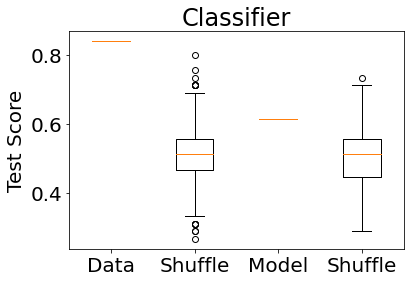

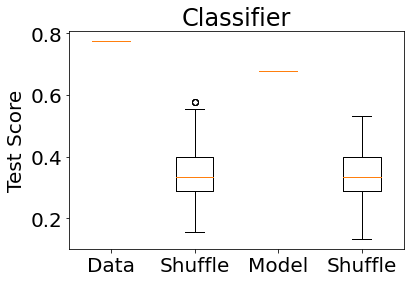

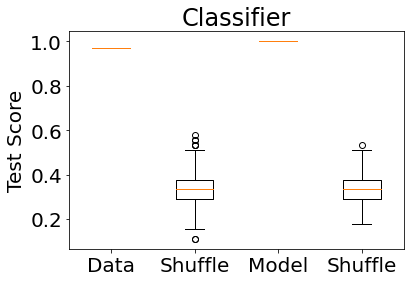

(0.9677419354838714, 0.33786666666666665, 1.0, 0.3295333333333333)

In [84]:

# Choice Prediction
# Temporal sectors
CueTime_end = np.where(np.diff(Iseries[:,0])==-1)[0]
StopTime = np.where(np.diff(Iseries[:,0])==1)[0]-49
# Data Set Mean Activity Zscore Neurons
num_trials = len(CueTime_end)
num_neurons = Nseries.shape[1]
Neural_train = np.zeros((num_trials,num_neurons))
Model_train = np.zeros((num_trials,num_neurons))
for it in range(num_trials):
    Neural_train[it,:]=np.mean(Nseries[StopTime[it]:CueTime_end[it],:],0)
    Model_train[it,:]=np.mean(Mseries[StopTime[it]:CueTime_end[it],:],0)


# Temporal sectors
CueTime_endT = np.where(np.diff(IseriesT[:,0])==-1)[0]
StopTimeT = np.where(np.diff(IseriesT[:,0])==1)[0]-49
# Data Set Mean Activity Zscore Neurons
num_trialsT = len(CueTime_endT)
num_neuronsT = MseriesT.shape[1]
Neural_test = np.zeros((num_trialsT,num_neuronsT))
Model_test = np.zeros((num_trialsT,num_neuronsT))
for it in range(num_trialsT):
    Neural_test[it,:]=np.mean(NseriesT[StopTimeT[it]:CueTime_endT[it],:],0)
    Model_test[it,:]=np.mean(MseriesT[StopTimeT[it]:CueTime_endT[it],:],0)

Classifier_events(Neural_train,Neural_test,Model_train,Model_test,ND,trials_train,trials_test)


# Reward Prediction
# Temporal sectors
RewTime_ini = np.where(np.diff(Iseries[:,0])==-1)[0]
RT_end = np.where(np.diff(Iseries[:,0])==1)[0]-49
RewTime_end = np.append(RT_end[1:],Iseries.shape[0])
# Data Set Mean Activity Zscore Neurons
num_trials = len(CueTime_end)
num_neurons = Nseries.shape[1]
Neural_train = np.zeros((num_trials,num_neurons))
Model_train = np.zeros((num_trials,num_neurons))
for it in range(num_trials):
    Neural_train[it,:]=np.mean(Nseries[RewTime_ini[it]:RewTime_end[it],:],0)
    Model_train[it,:]=np.mean(Mseries[RewTime_ini[it]:RewTime_end[it],:],0)


# Temporal sectors
RewTime_iniT = np.where(np.diff(IseriesT[:,0])==-1)[0]
RT_endT = np.where(np.diff(IseriesT[:,0])==1)[0]-49
RewTime_endT = np.append(RT_endT[1:],IseriesT.shape[0])
# Data Set Mean Activity Zscore Neurons
num_trialsT = len(CueTime_endT)
num_neuronsT = MseriesT.shape[1]
Neural_test = np.zeros((num_trialsT,num_neuronsT))
Model_test = np.zeros((num_trialsT,num_neuronsT))
for it in range(num_trialsT):
    Neural_test[it,:]=np.mean(NseriesT[RewTime_iniT[it]:RewTime_endT[it],:],0)
    Model_test[it,:]=np.mean(MseriesT[RewTime_iniT[it]:RewTime_endT[it],:],0)

Classifier_events(Neural_train,Neural_test,Model_train,Model_test,RW,trials_train,trials_test)

#Block Prediction
# Temporal sectors
TrialTime_ini = np.where(np.diff(Iseries[:,0])==1)[0]-49
TrialTime_end = np.append(TrialTime_ini[1:],Iseries.shape[0])
# Data Set Mean Activity Zscore Neurons
num_trials = len(CueTime_end)
num_neurons = Nseries.shape[1]
Neural_train = np.zeros((num_trials,num_neurons))
Model_train = np.zeros((num_trials,num_neurons))
for it in range(num_trials):
    Neural_train[it,:]=np.mean(Nseries[TrialTime_ini[it]:TrialTime_end[it],:],0)
    Model_train[it,:]=np.mean(Mseries[TrialTime_ini[it]:TrialTime_end[it],:],0)

# Temporal sectors
TrialTime_iniT = np.where(np.diff(IseriesT[:,0])==1)[0]-49
TrialTime_endT = np.append(TrialTime_iniT[1:],IseriesT.shape[0])
# Data Set Mean Activity Zscore Neurons
num_trialsT = len(CueTime_endT)
num_neuronsT = MseriesT.shape[1]
Neural_test = np.zeros((num_trialsT,num_neuronsT))
Model_test = np.zeros((num_trialsT,num_neuronsT))
for it in range(num_trialsT):
    Neural_test[it,:]=np.mean(NseriesT[TrialTime_iniT[it]:TrialTime_endT[it],:],0)
    Model_test[it,:]=np.mean(MseriesT[TrialTime_iniT[it]:TrialTime_endT[it],:],0)

Classifier_events(Neural_train,Neural_test,Model_train,Model_test,B_se,trials_train,trials_test)
